# Natural Language Processing - A Keras Model Exploration

#### References Used: ####

https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/

https://www.tutorialspoint.com/tensorflow/index.htm

https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/

# About the data

The data comes from a Kaggle dataset of 10,000 handselected tweets for a competition in machine learning.  The goal is to build a model that can predict whether a tweet was talking about a disaster or not, a binary feature.

### Files
* train.csv - the training set;
* test.csv - the test set;
* sample_submission.csv - a sample submission file in the correct format.

### Features table:

| Feature   | Description                                                 |
|-----------|-------------------------------------------------------------|
| id        | A unique identifier for each tweet.                         |
| text      | The text of the tweet.                                     |
| location  | The location from which the tweet was sent (may be blank). |
| keyword   | A specific keyword from the tweet (may be blank).           |
| target    | In the train.csv dataset only, indicates whether a tweet is about a real disaster (1) or not (0). |


# Libraries

In [64]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

from scipy.stats import randint
import seaborn as sns

# EDA & Data Cleansing

In [68]:
train_df = pd.read_csv('../Week 4 Project/data/train.csv')
test_df = pd.read_csv('../Week 4 Project/data/test.csv')
submission_sample = pd.read_csv('../Week 4 Project/data/sample_submission.csv')

In [69]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [70]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


C:\Users\bench\anaconda3\envs\Py310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


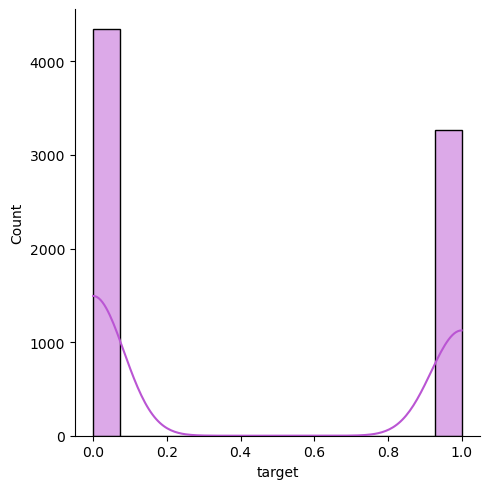

In [78]:
sns.displot(train_df['target'], kde=True, color='mediumorchid')

In [45]:
print(train_df['keyword'].isna().sum())
print(train_df['location'].isna().sum())

61
2533


It is clear that the NaN are going to be a problem.  I will need to clean it up before we can progress.

As we only need a binary indicator of whether a disaster has occured or not, the location is not useful information.  Thus the column can be removed.

In [46]:
train_df.drop('location', axis=1, inplace=True)
test_df.drop('location', axis=1, inplace=True)

Keyword is an essential feature to help attune the models, so I will need to work on cleansing this data.  I will be checking all of the unique words.

In [47]:
keywords = train_df['keyword'].unique()
keywords

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

It looks like the keywords themselves need some cleaning, as the spaces have been replaced by '%20'.  This needs to be reversed.

In [86]:
train_df['keyword'] = train_df['keyword'].str.replace('%20', ' ')
test_df['keyword'] = test_df['keyword'].str.replace('%20', ' ')

keywords = train_df['keyword'].unique()
keywords

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'desol

Now I'll transform this categorical variables in numerical, using LabelEncoding.  This step allows us to more easily use machine learning on the data.

In [49]:
label_encoder = LabelEncoder()
train_df['keyword encoded'] = label_encoder.fit_transform(train_df['keyword'])
train_df.drop('keyword', axis=1, inplace=True)
train_df['target value'] = train_df['target']
train_df.drop('target', axis=1,inplace=True)

train_df

,id,text,keyword encoded,target value
0,1,Our Deeds are the Reason of this #earthquake M...,221,1
1,4,Forest fire near La Ronge Sask. Canada,221,1
2,5,All residents asked to 'shelter in place' are ...,221,1
3,6,"13,000 people receive #wildfires evacuation or...",221,1
4,7,Just got sent this photo from Ruby #Alaska as ...,221,1
...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,221,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,221,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,221,1
7611,10872,Police investigating after an e-bike collided ...,221,1


In [50]:
label_encoder = LabelEncoder()
test_df['keyword encoded'] = label_encoder.fit_transform(test_df['keyword'])
test_df.drop('keyword', axis=1, inplace=True)
test_df

,id,text,keyword encoded
0,0,Just happened a terrible car crash,221
1,2,"Heard about #earthquake is different cities, s...",221
2,3,"there is a forest fire at spot pond, geese are...",221
3,9,Apocalypse lighting. #Spokane #wildfires,221
4,11,Typhoon Soudelor kills 28 in China and Taiwan,221
...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,221
3259,10865,Storm in RI worse than last hurricane. My city...,221
3260,10868,Green Line derailment in Chicago http://t.co/U...,221
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,221


The next step will be to perform Term Frequency-Inverse Document Frequency vectorization on the 'text' column. TF-IDF is a method used to determine the importance of a word in a document relative to a collection of documents. It combines term frequency (how often a word appears in a document) with inverse document frequency (how unique the word is across documents). By multiplying these factors, TF-IDF highlights words that are both frequent within the document and rare across the corpus, aiding in tasks like information retrieval and text mining.  I will be running the Tf-idf with TfidfVectorizer().

In [51]:
tfidf_vector = TfidfVectorizer()
tfidf_matrix = tfidf_vector.fit_transform(train_df['text'])
tfidf_features = tfidf_matrix.toarray()
feature_names = tfidf_vector.get_feature_names_out()
tfidf_data_frame = pd.DataFrame(data=tfidf_features, columns=feature_names)
train_combined = pd.concat([train_df, tfidf_data_frame], axis=1)

In [52]:
tfidf_matrix = tfidf_vector.transform(test_df['text'])
tfidf_features = tfidf_matrix.toarray()
feature_names = tfidf_vector.get_feature_names_out()
tfidf_data_frame = pd.DataFrame(data=tfidf_features, columns=feature_names)
test_combined = pd.concat([test_df, tfidf_data_frame], axis=1)

In [53]:
train_combined.drop('text', axis=1, inplace=True)
train_combined.drop('id', axis=1, inplace=True)

In [54]:
test_combined.drop('id', axis=1, inplace=True)
test_combined.drop('text', axis=1, inplace=True)

In [55]:
train_combined

,keyword encoded,target value,00,000,0000,007npen6lg,00cy9vxeff,00end,00pm,01,...,ûò,ûò800000,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûónegligence,ûótech,ûówe
0,221,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,221,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,221,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,221,1,0.0,0.417447,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,221,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,221,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,221,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,221,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.305284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,221,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
test_combined

,keyword encoded,00,000,0000,007npen6lg,00cy9vxeff,00end,00pm,01,02,...,ûò,ûò800000,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûónegligence,ûótech,ûówe
0,221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.30356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3259,221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3260,221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3261,221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

Let's get to some modeling!

Epoch 1/200
77/77 [==============================] - 2s 25ms/step - loss: 0.6866 - accuracy: 0.5827 - val_loss: 0.6465 - val_accuracy: 0.6149
Epoch 2/200
77/77 [==============================] - 2s 23ms/step - loss: 0.5612 - accuracy: 0.7459 - val_loss: 0.5798 - val_accuracy: 0.6806
Epoch 3/200
77/77 [==============================] - 2s 20ms/step - loss: 0.3620 - accuracy: 0.8758 - val_loss: 0.6053 - val_accuracy: 0.6741
Epoch 4/200
77/77 [==============================] - 2s 20ms/step - loss: 0.2318 - accuracy: 0.9216 - val_loss: 0.4627 - val_accuracy: 0.8103
Epoch 5/200
77/77 [==============================] - 1s 20ms/step - loss: 0.1402 - accuracy: 0.9575 - val_loss: 0.5283 - val_accuracy: 0.7931
Epoch 6/200
77/77 [==============================] - 1s 19ms/step - loss: 0.1068 - accuracy: 0.9665 - val_loss: 0.6817 - val_accuracy: 0.7652
Epoch 7/200
77/77 [==============================] - 1s 17ms/step - loss: 0.0690 - accuracy: 0.9815 - val_loss: 0.5696 - val_accuracy: 0.7865
Epoch 

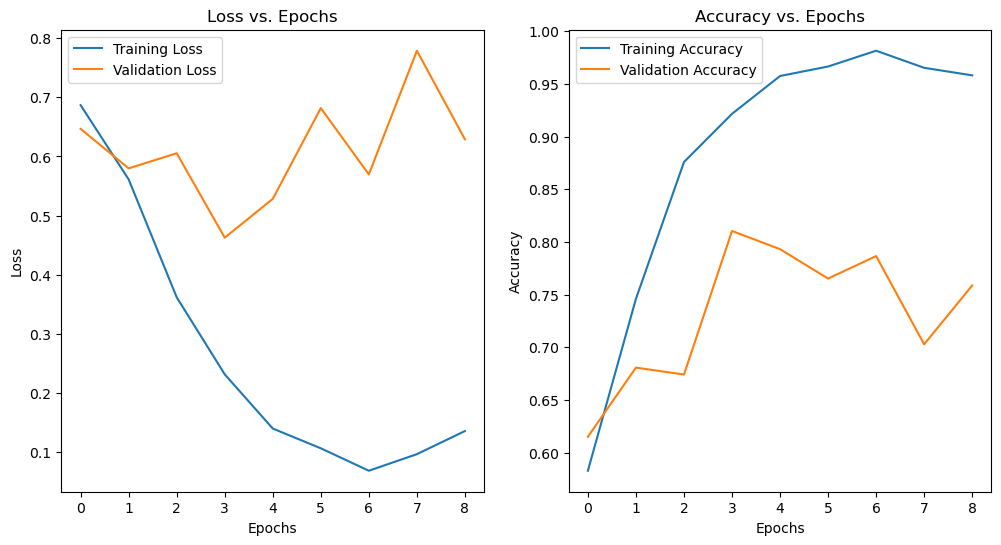

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [85]:
X = train_combined.drop('target value', axis=1)
Y = train_combined['target value']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4231)

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, min_delta=0.001, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=200,batch_size=64, validation_split=0.2,callbacks=[early_stopping],shuffle=True)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

f1 = f1_score(y_test, y_pred_binary)

print(f'F1 Score: {f1:.4f}')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.show()
y_pred_binary

The F1 score from the start is fairly average at 0.7422.  It suggests a reasonable balance between precision (how many selected instances are relevant) and recall (how many relevant instances are selected). However, I am going to attempt to see if it can be improved by some fine-tuning.

C:\Users\bench\anaconda3\envs\Py310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


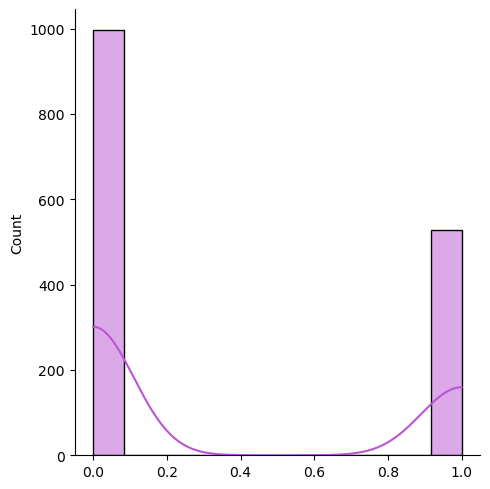

In [83]:
sns.displot(y_pred_binary.flatten(), kde=True, color='mediumorchid')

# Tuning

In [59]:
def create_model(hidden_units=64, activation='relu'):
    model = Sequential()
    model.add(Dense(hidden_units, activation=activation, input_dim=X_train.shape[1]))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_keras = KerasClassifier(build_fn=create_model, verbose=0)

param_dist = {'hidden_units': [64, 128, 256], 'activation': ['relu', 'tanh']}

random_search = RandomizedSearchCV(estimator=model_keras, param_distributions=param_dist, n_iter=10, scoring='f1', cv=3, verbose=3, n_jobs=-1)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best F1 score: {:.4f}".format(random_search.best_score_))



Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\bench\AppData\Local\Temp\ipykernel_25856\3313315839.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_keras = KerasClassifier(build_fn=create_model, verbose=0)


Best parameters found:  {'hidden_units': 128, 'activation': 'tanh'}
Best F1 score: 0.6010


Using RandomizedSearchCV, resulted in a significantly lower F1 score. of 0.6010

In [60]:
X_combined_test = test_combined.values
y_pred = model.predict(X_combined_test)
y_pred_binary = (y_pred > 0.5).astype(int)

102/102 [==============================] - 3s 28ms/step


In [61]:
submission_sample['target'] = y_pred_binary
submission_sample.to_csv("submission.csv", index=False)

# Conclusion

This is an example of how a straight-forward deep learning Keras model can achieve a fairly good F1 score.  This can be compared to RandomizedSearchCV, which was unable to get as good an F1 score.  The Tf-idf and Label Encoding allows for further information to be pulled from the data that allowed a good amount of actualization by the model.  I'm sure that there are better ways to further specialize the model, but this is a good enough start for now.